# Exploring the capabilities of the Transformers model.

This notebook implements a Transformers architecture with only layer which is repeated a certain number of time; we investigate how this architecture succeeds to learn modular addition. Besides, we investigate the learned parameters, the impact of depth of this Transformers. We remind that the Transformers model we propose is the following
$$x_{k}^{i+1}=x_{k}^{i}+\sum_{j=1}^{n}\frac{e^{\langle Qx_{k}^{i},K x_{j}^{i}\rangle}}{\sum_{t=1}^{n}e^{\langle Qx_{t}^{i},K x_{k}^{i}\rangle}}Vx_{j}^{i}.$$
We can see this model as an equivalent of the ResNet neural networks for Transformers with a same attention head which is repeated through the layers. We investigate the different performances according to depth.

# Imports and implementation

### Imports

In [ ]:
!nvidia-smi

Thu Jan 25 13:05:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install seaborn

In [ ]:
!pip install einops

In [ ]:
import os
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from tqdm.auto import tqdm
import math
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import torch.optim

In [ ]:
Z=sns.color_palette("Paired")

### Transformer implementation

In [ ]:
alpha=1
# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(alpha*torch.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(alpha*torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))

    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(alpha*torch.randn(max_ctx, d_model)/np.sqrt(d_model))

    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(alpha*torch.ones(d_model))
        self.b_ln = nn.Parameter(alpha*torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Linear(d_head, d_model)
        self.W_Q = nn.Linear(d_head, d_model)
        self.W_V = nn.Linear(d_head, d_model)
        self.W_O = nn.Linear(d_model, d_head )
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head

    def forward(self, x):
      ###computation of the scalar products
        W_k=self.W_K.weight
        W_q=self.W_Q.weight
        W_v=self.W_V.weight
        W_o=self.W_O.weight
        k =torch.einsum('hd,bpd->bph', W_k, x)
        q = torch.einsum('hd,bpd->bph',W_q, x)
        v = torch.einsum('hd,bpd->bph', W_v, x)
        attn_scores_pre = torch.einsum('bph,bqh->bqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = F.softmax((attn_scores_masked/np.sqrt(self.d_head)), dim=-1)
        z = torch.einsum('bph,bqp->bqh', v, attn_matrix)
        z_flat = einops.rearrange(z, 'b q h -> b q (h)')
        out = torch.einsum('df,bqf->bqd', W_o, z_flat)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model    #512 dim
        self.num_heads = num_heads   #8
        self.single_head_dim = int(self.d_model / self.num_heads)   #512/8 = 64  . each key,query, value will be of 64d

        #key,query and value matrixes    #64 x 64
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False)
        self.out = nn.Linear(self.num_heads*self.single_head_dim ,self.d_model)

    def forward(self,x,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512

        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder

        Returns:
           output vector from multihead attention
        """
        batch_size = x.size(0)
        seq_length = x.size(1)

        # query dimension can change in decoder during inference.
        # so we cant take general seq_length
        #seq_length_query = query.size(1)

        # 32x10x512
        key = x.view(batch_size, seq_length, self.num_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        query = x.view(batch_size, seq_length, self.num_heads, self.single_head_dim) #(32x10x8x64)
        value = x.view(batch_size, seq_length, self.num_heads, self.single_head_dim) #(32x10x8x64)

        k = self.key_matrix(key)       # (32x10x8x64)
        q = self.query_matrix(query)
        v = self.value_matrix(value)

        q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
        k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
        v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)

        # computes attention
        # adjust key for matrix multiplication
        k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
        product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)
        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))
        #divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim)
        #applying softmax
        scores = F.softmax(product, dim=-1)
        #mutiply with value matrix
        scores = torch.matmul(scores, v)
        #concatenated output
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length, self.single_head_dim*self.num_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)

        output = self.out(concat) #(32,10,512) -> (32,10,512)

        return output
# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(alpha*torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(alpha*torch.zeros(d_mlp))
        self.W_out = nn.Parameter(alpha*torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        self.ln = LayerNorm(d_mlp, model=self.model)
        assert act_type in ['ReLU', 'GeLU']

    def forward(self, x):
        x = torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = MultiHeadAttention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)

    def forward(self, x):
        x = x + self.attn(x)
        #x = x + self.mlp(x)
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type,depth, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache
        self.depth=depth

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        #for name, module in self.named_modules():
            #if type(module)==HookPoint:
             #   module.give_name(name)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
          for i in range(self.depth):
            x = block(x)
        x = self.ln(x)
        x = self.unembed(x)
        ##mettre un pooling

        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache


### Baseline training run

In [ ]:
def full_loss(model, data, device):
    loader = torch.utils.data.DataLoader(data, batch_size=len(data), shuffle=False)
    # Take the final position only
    x, labels = next(iter(loader))
    x = x.to(device)
    labels = labels.to(device)
    logits = model(x)[:, -1]
    return torch.nn.functional.cross_entropy(logits, labels)

def full_accuracy(model, data, device):
    loader = torch.utils.data.DataLoader(data, batch_size=len(data), shuffle=False)
    # Take the final position only
    x, labels = next(iter(loader))
    x = x.to(device)
    labels = labels.to(device)
    logits = model(x)[:, -1]
    predictions = torch.argmax(logits, dim=1)
    return torch.sum(predictions == labels).item() / len(labels)

## Data

In [ ]:
seed = 42
p = 113
fraction = 0.5
equals_token= p

In [ ]:
device='cuda'

In [ ]:
equals_token = p
fraction=0.5
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
plus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+1)
prompts = torch.stack([x, plus, y, equals], dim=1).to(device)
answers = ((x + y) % p).to(device)

data = torch.utils.data.TensorDataset(prompts, answers)
train, test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])
equals_token = p

# Training loop for modular addition (depth=2)

### Model declaration

In [ ]:
model = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=True, # use LayerNorm,
                    depth=2
                ).to(device)

### Training

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.945,patience=90, threshold=10e-8,verbose=True)
log_steps = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
test_minus= []
norms = []
Attn_wk_m=[]
Attn_wq_m=[]
Attn_wv_m=[]
for epoch in tqdm(range(50000)):
  train_loss = full_loss(model, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m.append(model.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps.append(epoch)
          test_loss = full_loss(model, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses.append(train_loss.item())
          test_losses.append(test_loss.item())
          train_accuracies.append(full_accuracy(model, train, device))
          test_accuracies.append(full_accuracy(model, test, device))
          norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f"%(epoch, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1], norms[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/50000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 5.239362 |  Test loss: 5.216642 | train_acc: 0.01 | test_acc: 0.01 | l2: 45.717804
epoch: 30  | Train loss: 4.688360 |  Test loss: 4.798217 | train_acc: 0.02 | test_acc: 0.00 | l2: 45.478236
epoch: 60  | Train loss: 4.516620 |  Test loss: 5.352347 | train_acc: 0.04 | test_acc: 0.00 | l2: 46.083453
epoch: 90  | Train loss: 4.283087 |  Test loss: 5.681230 | train_acc: 0.07 | test_acc: 0.00 | l2: 46.644391
epoch: 120  | Train loss: 4.080168 |  Test loss: 5.682763 | train_acc: 0.08 | test_acc: 0.00 | l2: 47.955841
epoch: 150  | Train loss: 3.913656 |  Test loss: 5.693313 | train_acc: 0.10 | test_acc: 0.00 | l2: 49.355422
epoch: 180  | Train loss: 3.482081 |  Test loss: 5.213844 | train_acc: 0.15 | test_acc: 0.01 | l2: 50.304197
epoch: 210  | Train loss: 3.182306 |  Test loss: 4.955772 | train_acc: 0.20 | test_acc: 0.01 | l2: 50.732858
epoch: 240  | Train loss: 2.995014 |  Test loss: 4.814272 | train_acc: 0.24 | test_acc: 0.03 | l2: 51.141622
epoch: 270  | Train loss

## Vizualization of the accuracy, rank and weight models dynamics

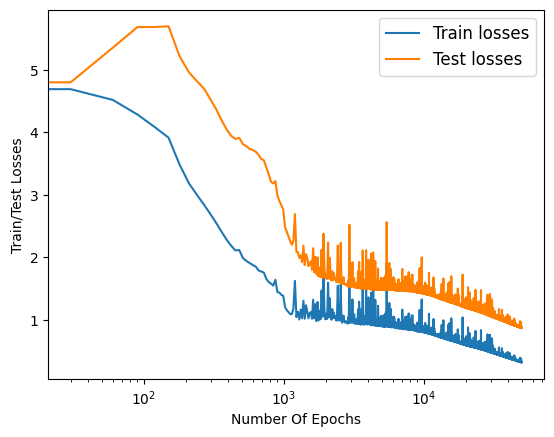

In [ ]:
plt.figure
plt.plot(log_steps,train_losses, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

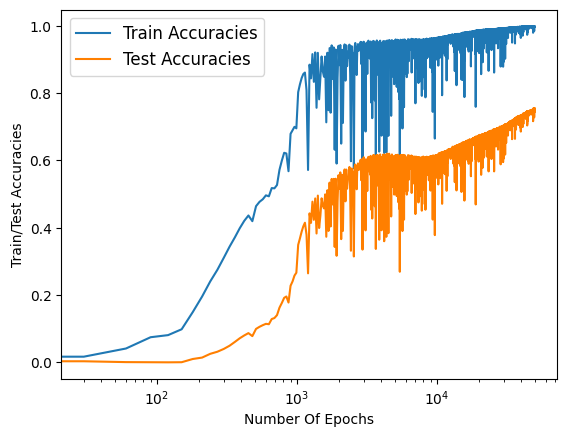

In [ ]:
plt.figure
plt.plot(log_steps,train_accuracies , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies, color=Z[7],label='Test Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

In [ ]:
rank_wk=[np.linalg.matrix_rank(x) for x in Attn_wk_m]
rank_wq_m=[np.linalg.matrix_rank(x) for x in Attn_wq_m]
rank_wv_m=[np.linalg.matrix_rank(x) for x in Attn_wv_m]

In [ ]:
rk_wk=[x/128 for x in rank_wk]
rk_wq=[x/128 for x in rank_wq_m]
rk_wv=[x/128 for x in rank_wv_m]

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(Attn_wv_m[-1])

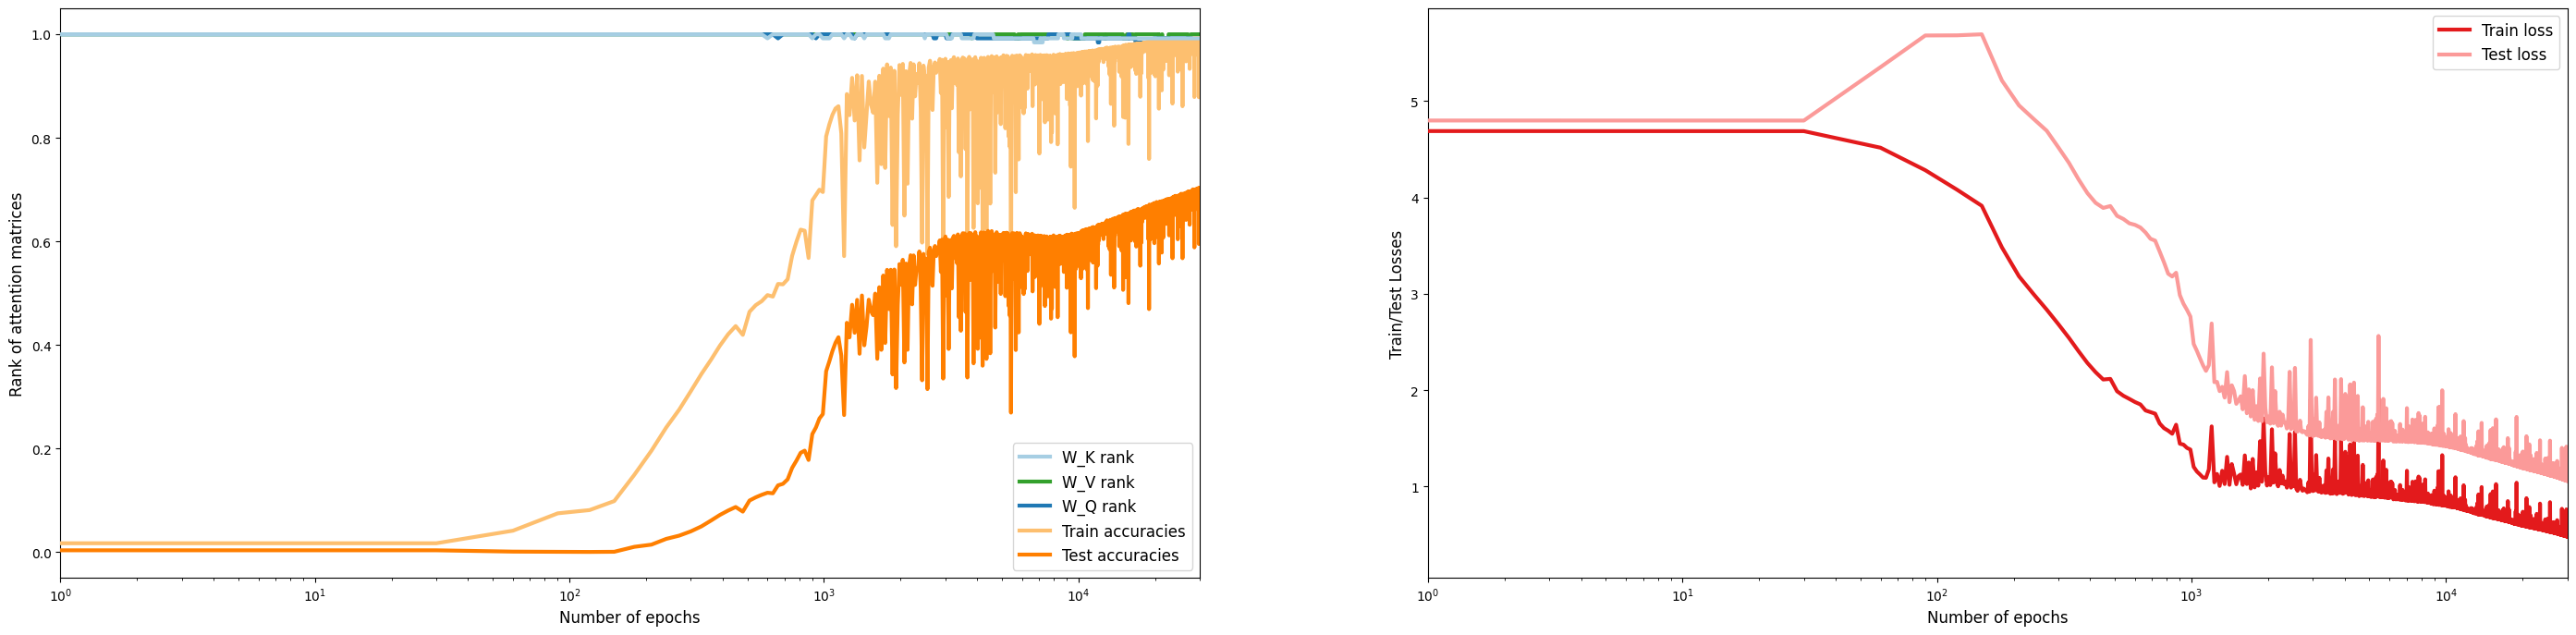

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,dpi=100,figsize=[35,8])

ax[0].plot(log_steps, rk_wk, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
ax[0].plot(log_steps, rk_wv, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
ax[0].plot(log_steps, rk_wq, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[0].plot(log_steps, train_accuracies, color=Z[6],linewidth=3, label='Train accuracies',zorder=3)
ax[0].plot(log_steps, test_accuracies, color=Z[7],linewidth=3, label='Test accuracies',zorder=3)
ax[0].legend()
ax[0].set_ylabel('Rank of attention matrices',fontsize='large')
ax[0].set_xlabel("Number of epochs",fontsize='large')
ax[0].set_xlim(1, 3*10**4)
ax[0].set_xscale('log')
ax[0].legend(fontsize='large')
#ax[1].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

ax[1].plot(log_steps, train_losses, color=Z[5],linewidth=3, label='Train loss',zorder=3)
ax[1].plot(log_steps, test_losses, color=Z[4],linewidth=3, label='Test loss',zorder=3)
#ax[2].plot(log_steps, rk_wk, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
#ax[2].plot(log_steps, rk_wv, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
#ax[2].plot(log_steps, rk_wq, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[1].legend()
ax[1].set_ylabel('Train/Test Losses',fontsize='large')
ax[1].set_xlabel("Number of epochs",fontsize='large')
ax[1].set_xlim(1, 3*10**4)
ax[1].set_xscale('log')
##ax[2].set_yscale('log')
ax[1].legend(fontsize='large')
#ax[2].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

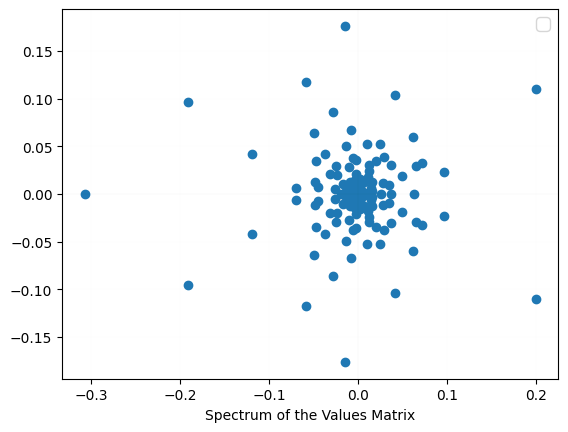

In [ ]:
plt.figure
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Spectrum of the Values Matrix')
plt.legend()
plt.legend(fontsize='large')

# Training loop for modular addition (depth=4)

### Model declaration

In [ ]:
model_4 = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=True, # use LayerNorm,
                    depth=4
                ).to(device)

### Training

In [ ]:
optimizer = torch.optim.AdamW(model_4.parameters(), lr=1e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=100, threshold=10e-8,verbose=True)
log_steps_4 = []
train_losses_4 = []
test_losses_4 = []
train_accuracies_4 = []
test_accuracies_4 = []
test_minus_4= []
norms_4 = []
Attn_wk_m_4=[]
Attn_wq_m_4=[]
Attn_wv_m_4=[]
for epoch in tqdm(range(50000)):
  train_loss = full_loss(model_4, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model_4.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m_4.append(model_4.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m_4.append(model_4.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m_4.append(model_4.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps_4.append(epoch)
          test_loss = full_loss(model_4, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses_4.append(train_loss.item())
          test_losses_4.append(test_loss.item())
          train_accuracies_4.append(full_accuracy(model_4, train, device))
          test_accuracies_4.append(full_accuracy(model_4, test, device))
          norms_4.append(np.sqrt(sum(param.pow(2).sum().item() for param in model_4.parameters())))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f"%(epoch, train_losses_4[-1], test_losses_4[-1], train_accuracies_4[-1], test_accuracies_4[-1], norms_4[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()


  0%|          | 0/50000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 5.297516 |  Test loss: 5.295416 | train_acc: 0.01 | test_acc: 0.01 | l2: 45.639766
epoch: 30  | Train loss: 4.696711 |  Test loss: 4.787851 | train_acc: 0.01 | test_acc: 0.01 | l2: 45.348767
epoch: 60  | Train loss: 4.553372 |  Test loss: 5.204123 | train_acc: 0.04 | test_acc: 0.00 | l2: 45.659597
epoch: 90  | Train loss: 4.325666 |  Test loss: 5.679446 | train_acc: 0.07 | test_acc: 0.00 | l2: 46.230390
epoch: 120  | Train loss: 4.103471 |  Test loss: 5.697412 | train_acc: 0.09 | test_acc: 0.00 | l2: 47.374007
epoch: 150  | Train loss: 3.712707 |  Test loss: 5.456452 | train_acc: 0.15 | test_acc: 0.00 | l2: 48.743661
epoch: 180  | Train loss: 3.126709 |  Test loss: 4.690618 | train_acc: 0.24 | test_acc: 0.01 | l2: 49.304900
epoch: 210  | Train loss: 2.691570 |  Test loss: 4.199111 | train_acc: 0.32 | test_acc: 0.03 | l2: 49.567424
epoch: 240  | Train loss: 2.498390 |  Test loss: 4.042895 | train_acc: 0.36 | test_acc: 0.04 | l2: 49.828742
epoch: 270  | Train loss

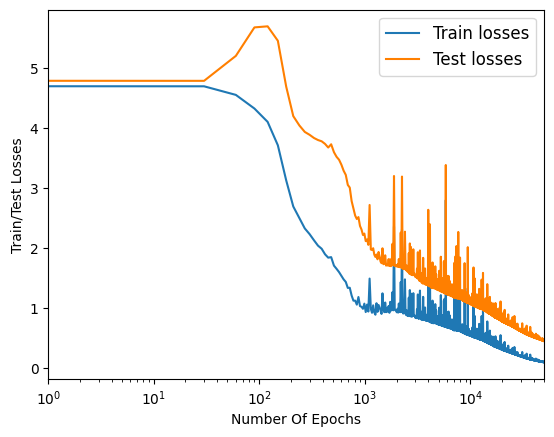

In [ ]:
plt.figure
plt.plot(log_steps_4,train_losses_4, color=Z[1],label='Train losses')
plt.plot(log_steps_4,test_losses_4, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
#plt.ylabel('Train/Test Accuracies')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.xlim(1, 5*10**4)
plt.show()

In [ ]:
plt.figure
plt.plot(log_steps_4,train_accuracies_4, color=Z[1],label='Train accuracies')
plt.plot(log_steps_4,test_accuracies_4, color=Z[7],label='Test accuracies')
plt.legend(fontsize='large')
plt.ylabel('Train/Test Accuracies')
plt.xlabel('Number Of Epochs')
plt.xscale('log')
plt.xlim(1, 5*10**4)
plt.show()

NameError: name 'log_steps_4' is not defined

In [ ]:
rank_wk_4=[np.linalg.matrix_rank(x) for x in Attn_wk_m_4]
rank_wq_m_4=[np.linalg.matrix_rank(x) for x in Attn_wq_m_4]
rank_wv_m_4=[np.linalg.matrix_rank(x) for x in Attn_wv_m_4]

In [ ]:
rk_wk_4=[x/128 for x in rank_wk_4]
rk_wq_4=[x/128 for x in rank_wq_m_4]
rk_wv_4=[x/128 for x in rank_wv_m_4]

In [ ]:
eigenvalues_4, eigenvectors_4 = np.linalg.eig(Attn_wv_m_4[-1])

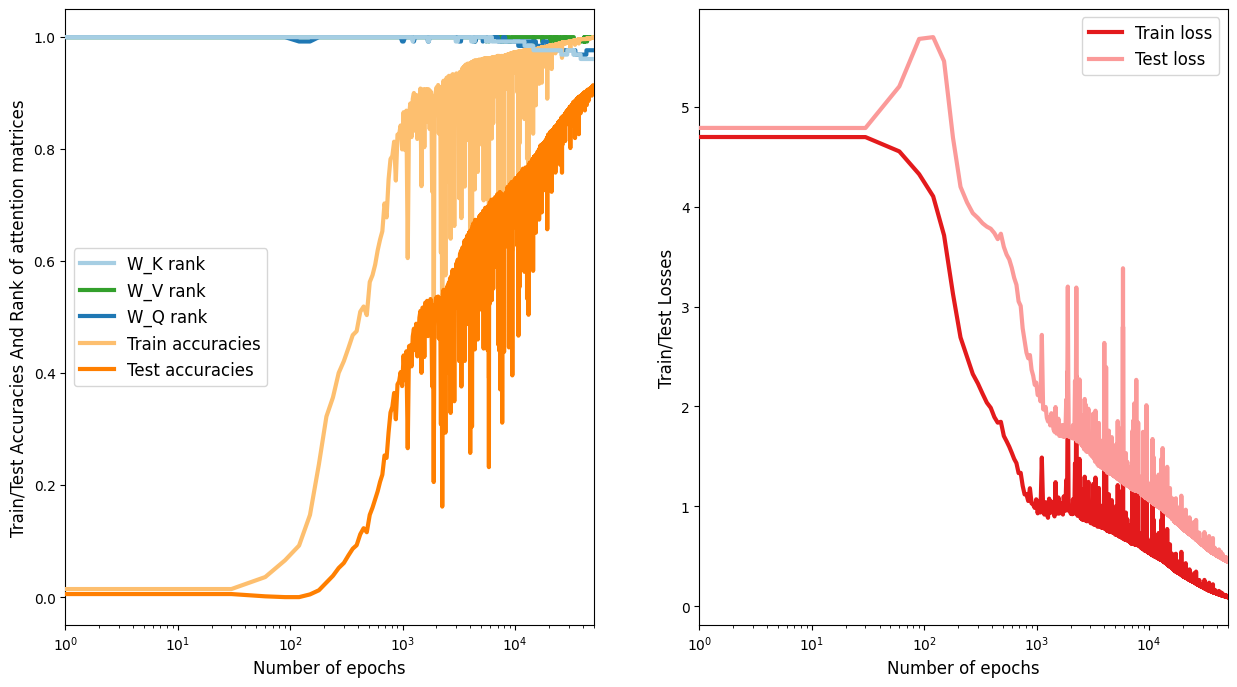

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,dpi=100,figsize=[15,8])

ax[0].plot(log_steps_4, rk_wk_4, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
ax[0].plot(log_steps_4, rk_wv_4, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
ax[0].plot(log_steps_4, rk_wq_4, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[0].plot(log_steps_4, train_accuracies_4, color=Z[6],linewidth=3, label='Train accuracies',zorder=3)
ax[0].plot(log_steps_4, test_accuracies_4, color=Z[7],linewidth=3, label='Test accuracies',zorder=3)
ax[0].legend()
ax[0].set_ylabel('Train/Test Accuracies And Rank of attention matrices',fontsize='large')
ax[0].set_xlabel("Number of epochs",fontsize='large')
ax[0].set_xlim(1, 5*10**4)
ax[0].set_xscale('log')
ax[0].legend(fontsize='large')
#ax[1].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

ax[1].plot(log_steps_4, train_losses_4, color=Z[5],linewidth=3, label='Train loss',zorder=3)
ax[1].plot(log_steps_4, test_losses_4, color=Z[4],linewidth=3, label='Test loss',zorder=3)
#ax[2].plot(log_steps, rk_wk, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
#ax[2].plot(log_steps, rk_wv, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
#ax[2].plot(log_steps, rk_wq, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[1].legend()
ax[1].set_ylabel('Train/Test Losses',fontsize='large')
ax[1].set_xlabel("Number of epochs",fontsize='large')
ax[1].set_xlim(1, 5*10**4)
ax[1].set_xscale('log')
##ax[2].set_yscale('log')
ax[1].legend(fontsize='large')
#ax[2].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

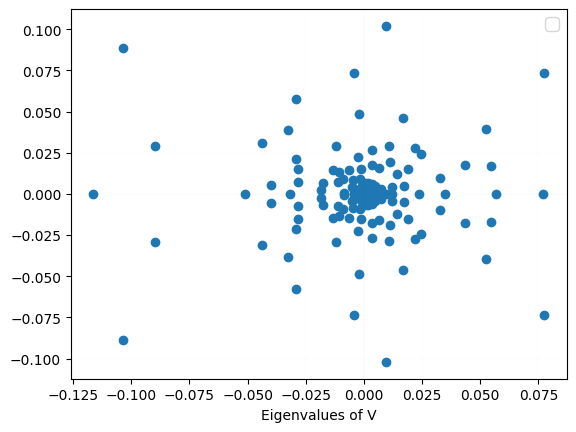

In [ ]:
plt.figure
plt.scatter(np.real(eigenvalues_4), np.imag(eigenvalues_4), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Eigenvalues of V')
plt.legend()
plt.legend(fontsize='large')

# Training loop for modular addition (depth=6)

### Model declaration

In [ ]:
model_6 = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=True, # use LayerNorm,
                    depth=6
                ).to(device)

### Training

In [17]:
optimizer = torch.optim.AdamW(model_6.parameters(), lr=1e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=90, threshold=10e-8,verbose=True)
log_steps_6 = []
train_losses_6 = []
test_losses_6 = []
train_accuracies_6 = []
test_accuracies_6 = []
norms_6 = []
Attn_wk_m_6=[]
Attn_wq_m_6=[]
Attn_wv_m_6=[]
for epoch in tqdm(range(50000)):
  train_loss = full_loss(model_6, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model_6.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m_6.append(model_6.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m_6.append(model_6.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m_6.append(model_6.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps_6.append(epoch)
          test_loss_6 = full_loss(model_6, test, device)
          test_2,train_2= test_loss_6.item(),train_loss.item()
          train_losses_6.append(train_loss.item())
          test_losses_6.append( test_loss_6.item())
          train_accuracies_6.append(full_accuracy(model_6, train, device))
          test_accuracies_6.append(full_accuracy(model_6, test, device))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f"%(epoch, train_losses_6[-1], test_losses_6[-1], train_accuracies_6[-1], test_accuracies_6[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/50000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 5.339003 |  Test loss: 5.330141 | train_acc: 0.01 | test_acc: 0.01
epoch: 30  | Train loss: 4.707073 |  Test loss: 4.770749 | train_acc: 0.02 | test_acc: 0.01
epoch: 60  | Train loss: 4.583426 |  Test loss: 5.111239 | train_acc: 0.03 | test_acc: 0.00
epoch: 90  | Train loss: 4.339220 |  Test loss: 5.581979 | train_acc: 0.06 | test_acc: 0.00
epoch: 120  | Train loss: 4.024056 |  Test loss: 5.614907 | train_acc: 0.11 | test_acc: 0.00
epoch: 150  | Train loss: 3.447083 |  Test loss: 4.993486 | train_acc: 0.18 | test_acc: 0.01
epoch: 180  | Train loss: 2.756413 |  Test loss: 4.120852 | train_acc: 0.30 | test_acc: 0.02
epoch: 210  | Train loss: 2.466260 |  Test loss: 3.872054 | train_acc: 0.37 | test_acc: 0.03
epoch: 240  | Train loss: 2.295358 |  Test loss: 3.769299 | train_acc: 0.42 | test_acc: 0.05
epoch: 270  | Train loss: 2.157624 |  Test loss: 3.727376 | train_acc: 0.45 | test_acc: 0.06
epoch: 300  | Train loss: 2.060968 |  Test loss: 3.716381 | train_acc: 0.47

## Vizualization of the accuracy, rank and weight models dynamics

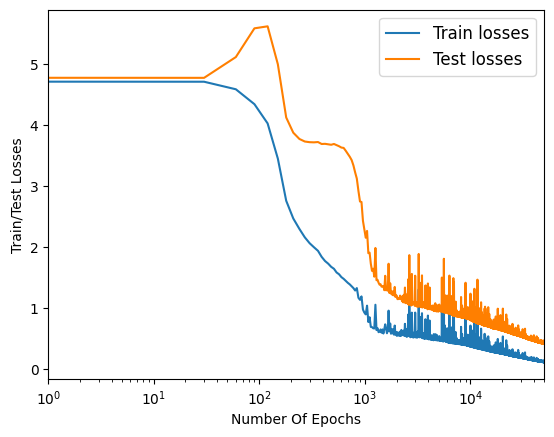

In [24]:
plt.figure
plt.plot(log_steps_6,train_losses_6, color=Z[1],label='Train losses')
plt.plot(log_steps_6,test_losses_6, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.xlim([1,50000])
plt.show()

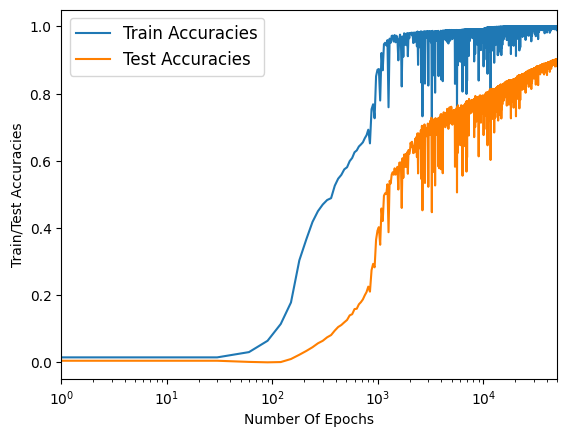

In [25]:
plt.figure
plt.plot(log_steps_6 ,train_accuracies_6 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps_6 ,test_accuracies_6, color=Z[7],label='Test Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.xlim([1,50000])
plt.show()

In [30]:
rank_wk=[np.linalg.matrix_rank(x) for x in Attn_wk_m_6]
rank_wq_m=[np.linalg.matrix_rank(x) for x in Attn_wq_m_6]
rank_wv_m=[np.linalg.matrix_rank(x) for x in Attn_wv_m_6]

In [31]:
rk_wk=[x/128 for x in rank_wk]
rk_wq=[x/128 for x in rank_wq_m]
rk_wv=[x/128 for x in rank_wv_m]

In [32]:
eigenvalues, eigenvectors = np.linalg.eig(Attn_wv_m_6[-1])

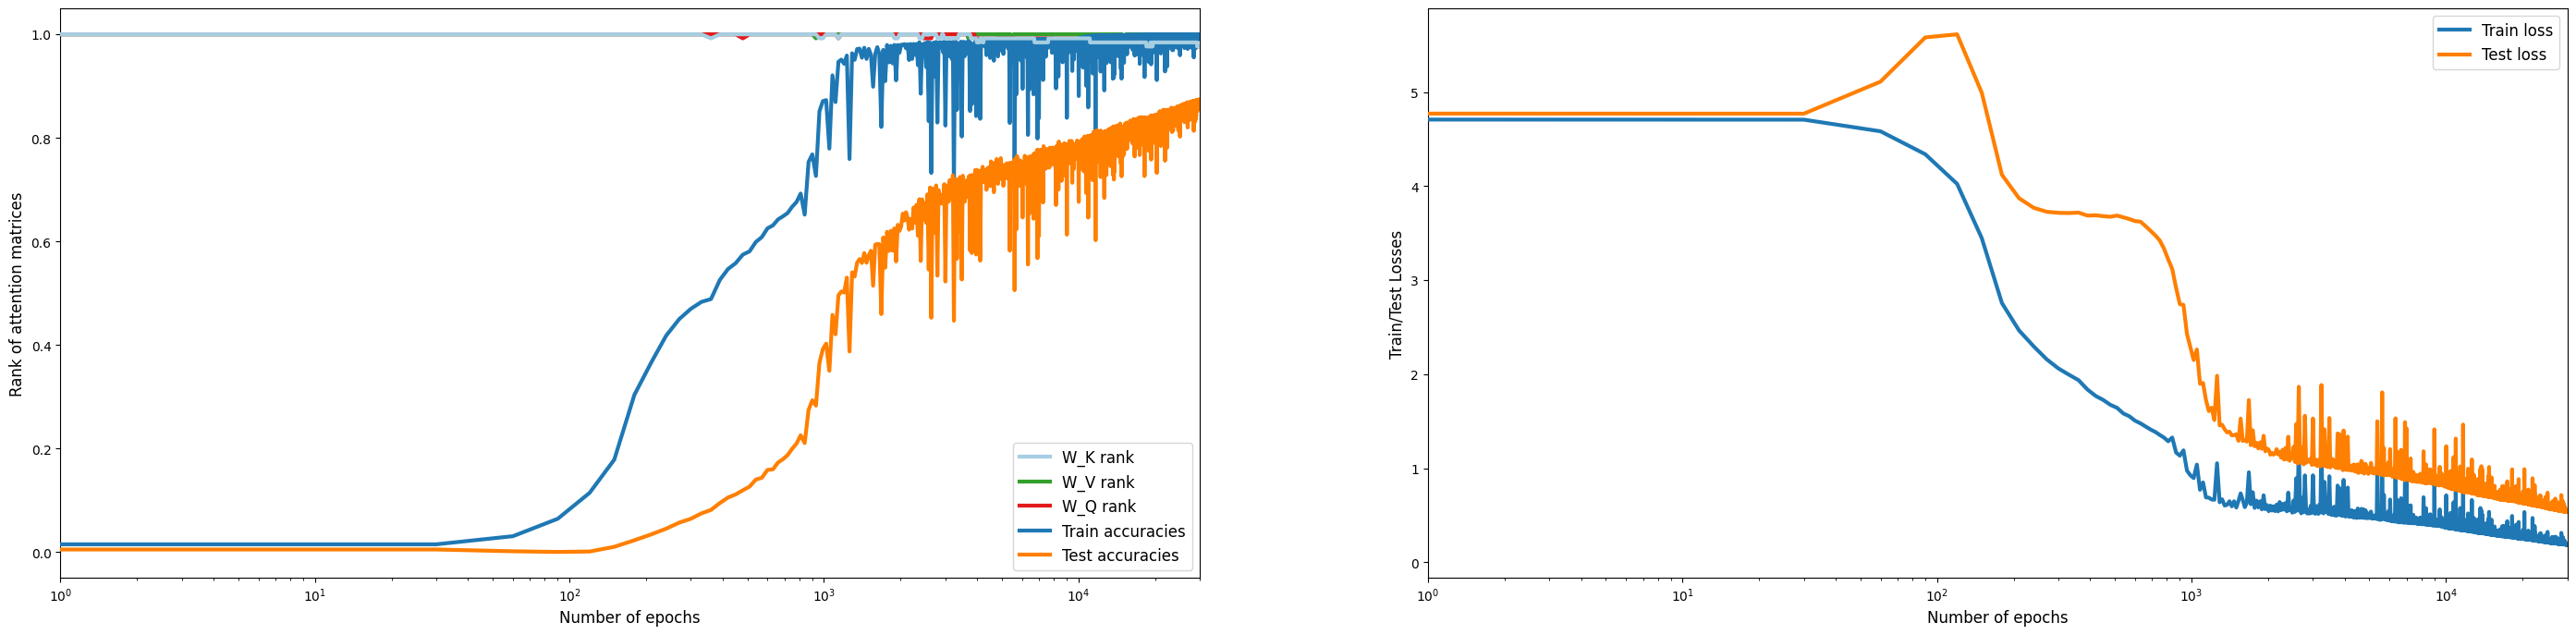

In [35]:
fig,ax=plt.subplots(nrows=1,ncols=2,dpi=100,figsize=[35,8])

ax[0].plot(log_steps_6, rk_wk, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
ax[0].plot(log_steps_6, rk_wv, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
ax[0].plot(log_steps_6, rk_wq, color=Z[5],linewidth=3, label='W_Q rank',zorder=3)
ax[0].plot(log_steps_6, train_accuracies_6, color=Z[1],linewidth=3, label='Train accuracies',zorder=3)
ax[0].plot(log_steps_6, test_accuracies_6, color=Z[7],linewidth=3, label='Test accuracies',zorder=3)
ax[0].legend()
ax[0].set_ylabel('Rank of attention matrices',fontsize='large')
ax[0].set_xlabel("Number of epochs",fontsize='large')
ax[0].set_xlim(1, 3*10**4)
ax[0].set_xscale('log')
ax[0].legend(fontsize='large')
#ax[1].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

ax[1].plot(log_steps_6, train_losses_6, color=Z[1],linewidth=3, label='Train loss',zorder=3)
ax[1].plot(log_steps_6, test_losses_6, color=Z[7],linewidth=3, label='Test loss',zorder=3)
#ax[2].plot(log_steps, rk_wk, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
#ax[2].plot(log_steps, rk_wv, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
#ax[2].plot(log_steps, rk_wq, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[1].legend()
ax[1].set_ylabel('Train/Test Losses',fontsize='large')
ax[1].set_xlabel("Number of epochs",fontsize='large')
ax[1].set_xlim(1, 3*10**4)
ax[1].set_xscale('log')
##ax[2].set_yscale('log')
ax[1].legend(fontsize='large')
#ax[2].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

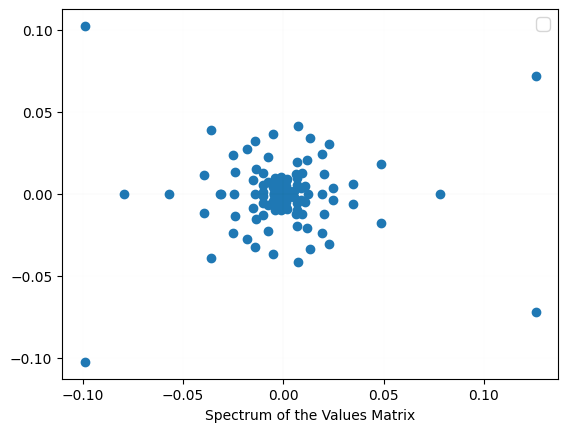

In [33]:
plt.figure
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Spectrum of the Values Matrix')
plt.legend()
plt.legend(fontsize='large')

# Training loop for modular addition (depth=8)

### Model declaration

In [36]:
model_8 = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=True, # use LayerNorm,
                    depth=8
                ).to(device)

### Training

In [37]:
optimizer = torch.optim.AdamW(model_8.parameters(), lr=1e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=100, threshold=10e-8,verbose=True)
log_steps_8 = []
train_losses_8 = []
test_losses_8 = []
train_accuracies_8 = []
test_accuracies_8 = []
test_minus_8= []
norms_8 = []
Attn_wk_m_8=[]
Attn_wq_m_8=[]
Attn_wv_m_8=[]
for epoch in tqdm(range(50000)):
  train_loss = full_loss(model_8, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model_8.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m_8.append(model_8.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m_8.append(model_8.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m_8.append(model_8.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps_8.append(epoch)
          test_loss = full_loss(model_8, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses_8.append(train_loss.item())
          test_losses_8.append(test_loss.item())
          train_accuracies_8.append(full_accuracy(model_8, train, device))
          test_accuracies_8.append(full_accuracy(model_8, test, device))
          norms_8.append(np.sqrt(sum(param.pow(2).sum().item() for param in model_8.parameters())))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f"%(epoch, train_losses_8[-1], test_losses_8[-1], train_accuracies_8[-1], test_accuracies_8[-1], norms_8[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()


  0%|          | 0/50000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 5.212795 |  Test loss: 5.173961 | train_acc: 0.01 | test_acc: 0.01 | l2: 45.581330
epoch: 30  | Train loss: 4.718165 |  Test loss: 4.754570 | train_acc: 0.01 | test_acc: 0.01 | l2: 45.241936
epoch: 60  | Train loss: 4.631195 |  Test loss: 4.997231 | train_acc: 0.02 | test_acc: 0.00 | l2: 45.293445
epoch: 90  | Train loss: 4.417629 |  Test loss: 5.410350 | train_acc: 0.05 | test_acc: 0.00 | l2: 45.849044
epoch: 120  | Train loss: 4.138058 |  Test loss: 5.540471 | train_acc: 0.09 | test_acc: 0.00 | l2: 46.930214
epoch: 150  | Train loss: 3.571399 |  Test loss: 5.017183 | train_acc: 0.16 | test_acc: 0.01 | l2: 47.943082
epoch: 180  | Train loss: 3.031837 |  Test loss: 4.320719 | train_acc: 0.24 | test_acc: 0.02 | l2: 48.289948
epoch: 210  | Train loss: 2.638248 |  Test loss: 3.926013 | train_acc: 0.33 | test_acc: 0.02 | l2: 48.489033
epoch: 240  | Train loss: 2.458752 |  Test loss: 3.816886 | train_acc: 0.37 | test_acc: 0.03 | l2: 48.715900
epoch: 270  | Train loss

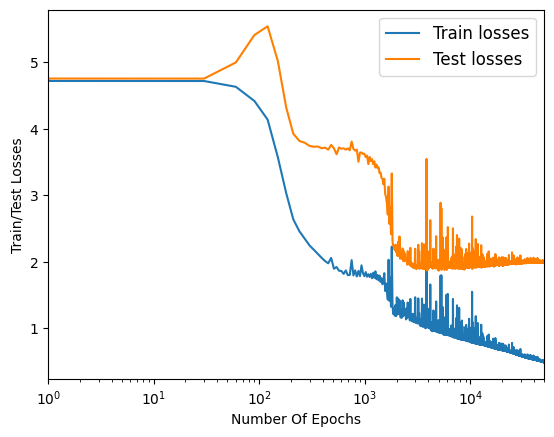

In [38]:
plt.figure
plt.plot(log_steps_8,train_losses_8, color=Z[1],label='Train losses')
plt.plot(log_steps_8,test_losses_8, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
#plt.ylabel('Train/Test Accuracies')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.xlim(1, 5*10**4)
plt.show()

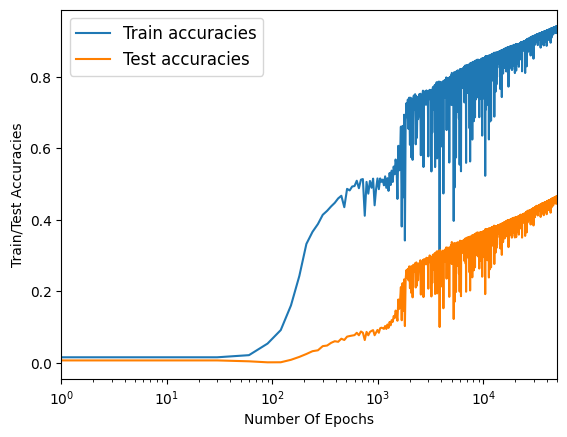

In [39]:
plt.figure
plt.plot(log_steps_8,train_accuracies_8, color=Z[1],label='Train accuracies')
plt.plot(log_steps_8,test_accuracies_8, color=Z[7],label='Test accuracies')
plt.legend(fontsize='large')
plt.ylabel('Train/Test Accuracies')
plt.xlabel('Number Of Epochs')
plt.xscale('log')
plt.xlim(1, 5*10**4)
plt.show()

In [40]:
eigenvalues_8, eigenvectors_8 = np.linalg.eig(Attn_wv_m_8[-1])

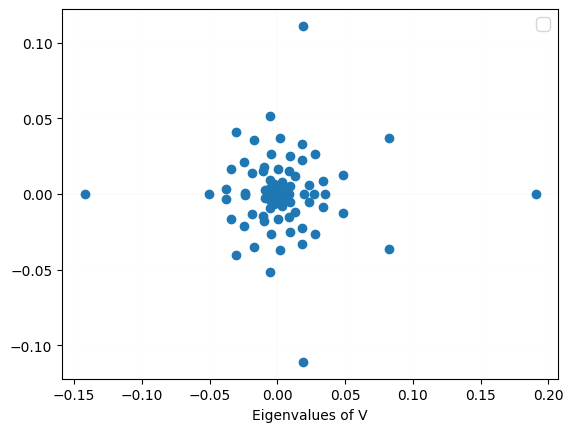

In [42]:
plt.figure
plt.scatter(np.real(eigenvalues_8), np.imag(eigenvalues_8), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Eigenvalues of V')
plt.legend()
plt.legend(fontsize='large')